In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob

In [3]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume
from scipy.interpolate import RegularGridInterpolator, griddata

Make sure we have a local directory to read the data from, and that the data is there

In [202]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_data.npy


Pick a dataset by its keyword

In [203]:
keyword='particle_highres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

Let's have a look at the structure

In [6]:
ipv.quickscatter(structure[:,0], structure[:,1], structure[:,2], size=10*structure[:,3], marker='sphere')

Now let's check the volume

In [7]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/fpoitevi/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


And now a few of the projection images

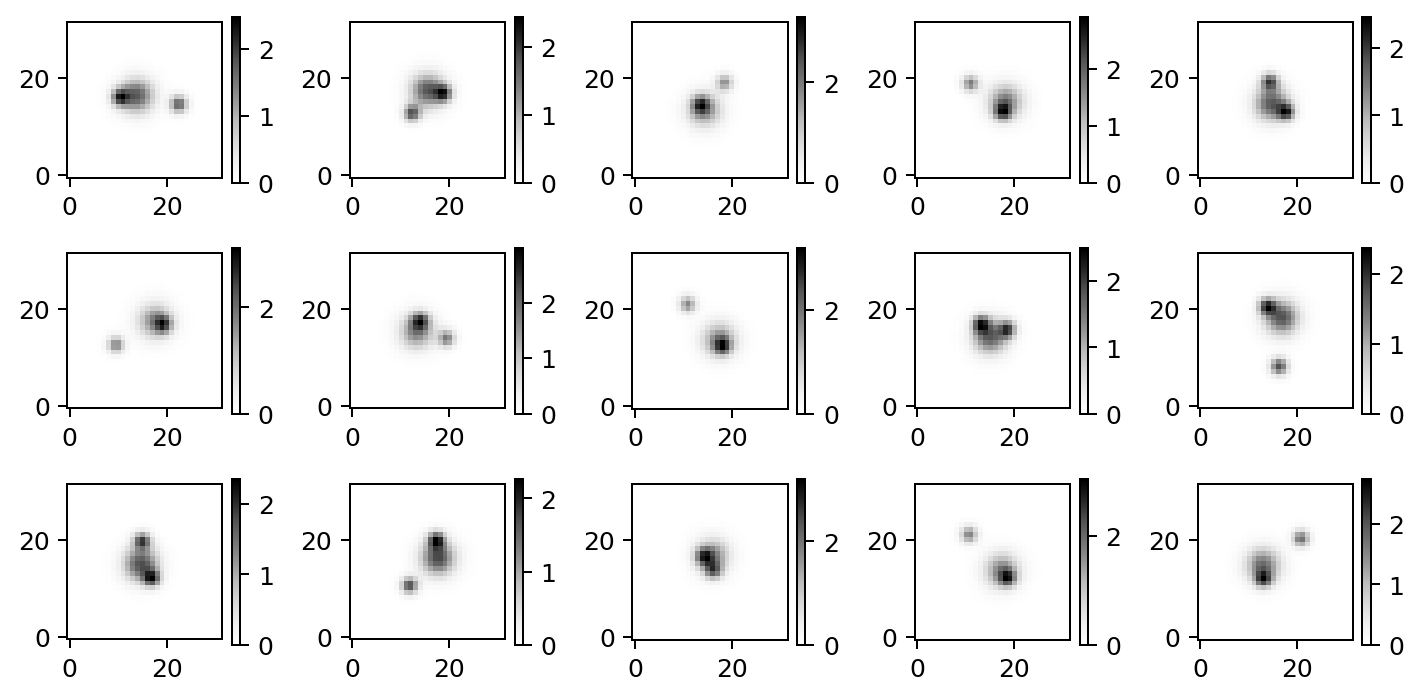

In [8]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4), dpi=180)
k=0
for i in np.arange(nrows):
    for j in np.arange(ncols):
        #axes[i,j].plot(metadataset[k,0:3])
        ax = axes[i,j]
        ims = ax.imshow(dataset[k], cmap='Greys', origin='lower')
        fig.colorbar(ims, ax=ax)
        k+=1
plt.tight_layout()
plt.show()

# Projections
We now look into projections where instead of rotation the particle, we rotate the slicing plane

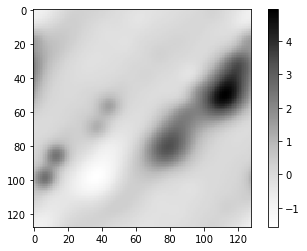

In [6]:
#Rot = R.random(random_state = 0)
#Rot = R.from_euler('x', 0, degrees = True)
Rot = R.from_rotvec(metadataset[0,0:3])
projection = project_volume(volume, Rot)
plt.imshow(projection, cmap='Greys')
plt.colorbar()

In [12]:
#Note from Fred: j'en suis la. J'ai pas eu le temps de finir...

In [204]:
def project_volume_bis(volume, Rotation):
    """
    This function rotate volume by Rotation
    """
    N = volume.shape[0]
    volume_ = np.zeros((N,N), dtype=np.complex_)
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    z = np.linspace(-1,1,N)
    interpolating_function = RegularGridInterpolator(points=[x,y,z],values=volume,bounds_error = False, fill_value=0)

    grid_x, grid_y,grid_z  = np.meshgrid(x,y,z, indexing='ij')
    points = np.stack([grid_x.ravel(),grid_y.ravel(), grid_z.ravel()],1)
    rot_points = Rotation.apply(points)

    volume_ = interpolating_function(rot_points)
    return volume_.reshape((N,N,N), order='C')

We want to see if the project_volume_bis function works correctly, to do so we compare the elements of the dataset (first column) with the projection obtained using the project_volume_bis function (second column)
We also compare these projections with those obtained via the slice-projection theorem (without and with oversampling of the volume in real space via zero padding, third and fourth columns)

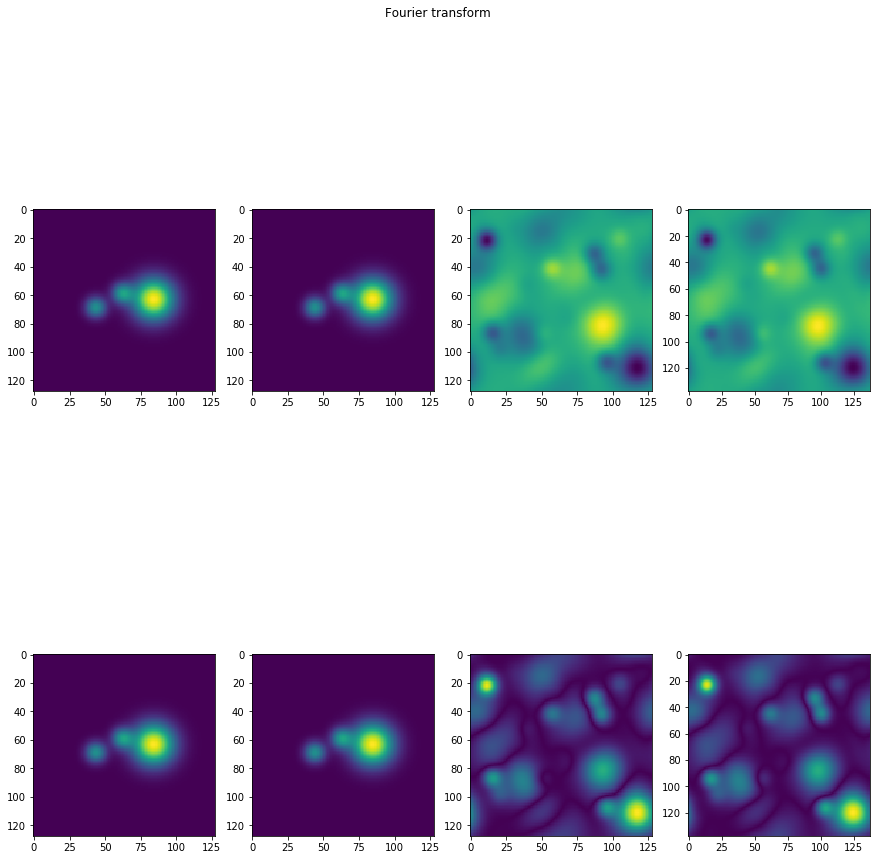

In [481]:
i=3
Rotation = (R.from_rotvec(-metadataset[i,0:3]))
N=volume.shape[0]
rot_volume = project_volume_bis(volume, Rotation)
im = np.sum(rot_volume, axis=2) #second column

over_volume = np.zeros((N+10,N+10,N+10))
over_volume[5:N+5,5:N+5,5:N+5] = volume

Rot = R.from_rotvec(-metadataset[i,0:3])
over_projection = project_volume(over_volume, Rot) #third column
projection = project_volume(volume, Rot) #fourth column

fig, ax = plt.subplots(2, 4, figsize=(15,15))
fig.suptitle('Fourier transform')
ax[0,0].imshow(np.real(dataset[i]))
ax[0,1].imshow(np.real(im))
ax[0,2].imshow(np.real(projection))
ax[0,3].imshow(np.real(over_projection))


ax[1,0].imshow(np.abs(dataset[i]))
ax[1,1].imshow(np.abs(im))
ax[1,2].imshow(np.abs(projection))
ax[1,3].imshow(np.abs(over_projection))

In [478]:
def slice_volume_bis(vol, Rotation):
    """
    Take a slice out of volume
    This function interpolates amplitude and phase separately, while the slice_volume function works by interpolating 
    real and complex values separately.
    """
    N = vol.shape[0]
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    z = np.linspace(-1,1,N)
    interpolating_function_mag = RegularGridInterpolator(points=[x,y,z],values=np.abs(vol),bounds_error = False, fill_value = 0)
    interpolating_function_ph = RegularGridInterpolator(points=[x,y,z],values=np.angle(vol),bounds_error = False, fill_value = None)

    grid_x, grid_y = np.meshgrid(x,y, indexing='ij')
    zeros = np.zeros((grid_x.shape))
    points = np.stack([grid_x.ravel(),grid_y.ravel(), zeros.ravel()],1)
    rot_points = Rotation.apply(points)

    image = interpolating_function_mag(rot_points)*np.exp(1j*interpolating_function_ph(rot_points))
    #image = 1j*interpolating_function_imag(rot_points)+interpolating_function_real(rot_points)

    return image.reshape(N,N)

We want to compare the fourier transform of the projection, depending on the interpolation process. First columns is the projection in the dataset, second column is the projection by rotated the volume first (using project_volume_bis), third column and fourth column are the slice obtained via direct interpolation of the fourier transformed volume.

/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


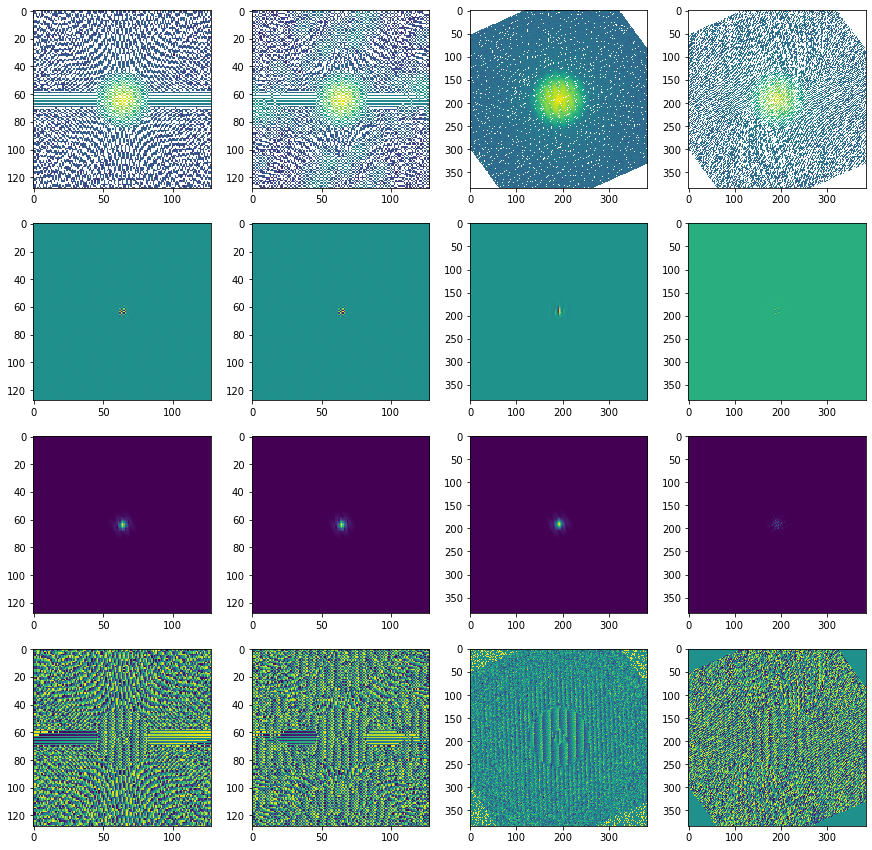

In [503]:
a=np.fft.fftshift(np.fft.fft2(dataset[i]))
b=np.fft.fftshift(np.fft.fft2(im))

N=volume.shape[0]
over_volume = np.zeros((3*N,3*N,3*N))
over_volume[N:2*N,N:2*N,N:2*N] = volume

Rotation = R.from_rotvec(-metadataset[i,0:3])
over_vol_shift = np.fft.fftshift(np.fft.fftn(over_volume))
c = slice_volume_bis(over_vol_shift, Rotation)
d = slice_volume(over_vol_shift, Rotation)


fig, ax = plt.subplots(4, 4, figsize=(15,15))
ax[0,0].imshow(np.log(np.real(a)))
ax[0,1].imshow(np.log(np.real(b)))
ax[0,2].imshow(np.log(np.real(c)))
ax[0,3].imshow(np.log(np.real(d)))

ax[1,0].imshow(np.imag(a))
ax[1,1].imshow(np.imag(b))
ax[1,2].imshow(np.imag(c))
ax[1,3].imshow(np.imag(d))

ax[2,0].imshow(np.abs(a))
ax[2,1].imshow(np.abs(b))
ax[2,2].imshow(np.abs(c))
ax[2,3].imshow(np.abs(d))

ax[3,0].imshow(np.angle(a))
ax[3,1].imshow(np.angle(b))
ax[3,2].imshow(np.angle(c))
ax[3,3].imshow(np.angle(d))


As it seems the angled slice is our problem, we can instead try to rotate the volume first (in real or fourier space) and then take the center slice (along z axis) which is easier to compute. First two columns are obtained by rotating the volume in real space, then take the fourier transform (one is first oversampled in real space). Third and fourth columns are obtained by rotating the volume in fourier space (one is first oversampled in real space).

In [388]:
def take_slice(vol):
    n=vol.shape[0]
    return (vol[:,:,n//2]+vol[:,:,n//2+1])/2

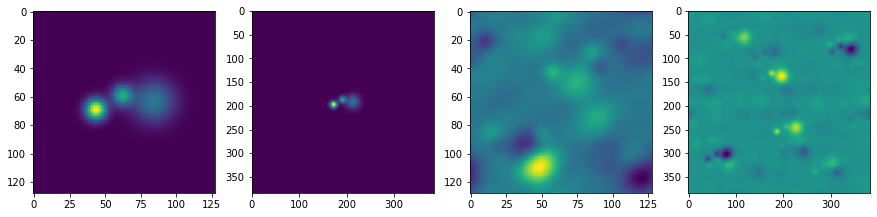

In [527]:
Rotation = (R.from_rotvec(-metadataset[i,0:3]))
rot_volume = project_volume_bis(volume, Rotation)
rot_over_volume = project_volume_bis(over_volume, Rotation)

rot_fft_volume = project_volume_bis(np.fft.fftshift(np.fft.fftn(volume)), Rotation)
rot_fft_over_volume = project_volume_bis(np.fft.fftshift(np.fft.fftn(over_volume)), Rotation)

fig, ax = plt.subplots(1, 4, figsize=(15,15))
ax[0].imshow(np.real(np.fft.ifft2(np.fft.ifftshift(take_slice(np.fft.fftshift(np.fft.fftn(rot_volume)))))))
ax[1].imshow(np.real(np.fft.ifft2(np.fft.ifftshift(take_slice(np.fft.fftshift(np.fft.fftn(rot_over_volume)))))))
ax[2].imshow(np.real(np.fft.ifft2(np.fft.ifftshift(take_slice(rot_fft_volume)))))
ax[3].imshow(np.real(np.fft.ifft2(np.fft.ifftshift(take_slice(rot_fft_over_volume)))))

It seams that the problems actually comes from interpolating values in the fourier space. We can now try to mask high frequency before taking the inverse fourier transform !

In [489]:
def create_circular_mask(N, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(N/2), int(N/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], N-center[0], N-center[1])

    Y, X = np.ogrid[:N, :N]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log
/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.7/site-p

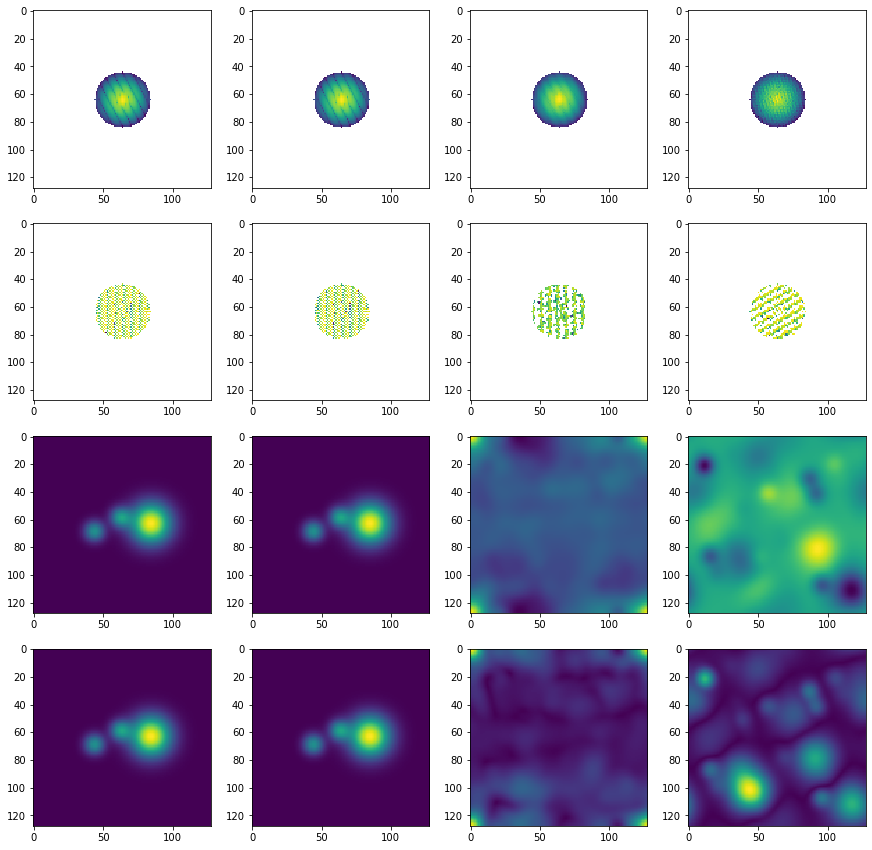

In [535]:
N = volume.shape[0]
i=3
Rotation = (R.from_rotvec(-metadataset[i,0:3]))
mask = create_circular_mask(N, radius = 20)
vol_shift = np.fft.fftshift(np.fft.fftn(volume))



a=np.fft.fftshift(np.fft.fft2(dataset[i]))
a[~mask] = 0
b=np.fft.fftshift(np.fft.fft2(im))
b[~mask] = 0
c = slice_volume_bis(vol_shift, Rotation)
c[~mask] = 0
d = slice_volume(vol_shift, Rotation)
d[~mask] = 0


fig, ax = plt.subplots(4, 4, figsize=(15,15))
ax[0,0].imshow(np.log(np.abs(a)))
ax[0,1].imshow(np.log(np.abs(b)))
ax[0,2].imshow(np.log(np.abs(c)))
ax[0,3].imshow(np.log(np.abs(d)))

ax[1,0].imshow(np.log(np.angle(a)))
ax[1,1].imshow(np.log(np.angle(b)))
ax[1,2].imshow(np.log(np.angle(c)))
ax[1,3].imshow(np.log(np.angle(d)))

ax[2,0].imshow(np.fft.ifft2(np.fft.ifftshift(a)).real)
ax[2,1].imshow(np.fft.ifft2(np.fft.ifftshift(b)).real)
ax[2,2].imshow(np.fft.ifft2(np.fft.ifftshift(c)).real)
ax[2,3].imshow(np.fft.ifft2(np.fft.ifftshift(d)).real)

ax[3,0].imshow(np.abs(np.fft.ifft2(a)))
ax[3,1].imshow(np.abs(np.fft.ifft2(b)))
ax[3,2].imshow(np.abs(np.fft.ifft2(c)))
ax[3,3].imshow(np.abs(np.fft.ifft2(d)))



In [467]:
def backprojection1(images, orientations):
    """
    working on it...
    backprojection with conventional method (the orientations are assigned)
    """
    N = images[0].shape[0]
    dico = {}
    index_images = np.arange(len(images))
    index = np.arange(N)
    for n in index_images:
        images_n = np.fft.fftshift(np.fft.fft2(images[n]))
        rot = R.from_rotvec(-orientations[n]) #transpose
        for i in index:
            x = -1 + i*2/(N-1)
            for j in index:
                y = -1 + j*2/(N-1)
                vect = np.array((x,y,0))
                vect_ = rot.apply(vect)
                key = np.array2string(vect_, precision=3, separator=',', suppress_small=True)
                if key in dico.keys():
                    dico[key][0] += images_n[i,j]
                    dico[key][1] +=1
                else:
                    dico[key] = np.array((images_n[i,j], 1))

    points = np.zeros((len(dico), 3))
    values = np.zeros(len(dico),dtype=complex)
    ctr = 0
    for keys in dico.keys():
        points[ctr] = eval('np.array(' + keys + ')')
        values[ctr] = dico[keys][0] / dico[keys][1].real
        ctr+=1
    
    grid_x, grid_y, grid_z = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N),np.linspace(-1,1,N))
    volume = griddata(points,values, (grid_x, grid_y, grid_z), fill_value=0)
    
    print(volume)
    return np.fft.ifftshift(np.fft.ifftn(volume))

In [469]:
def reconstruct(dataset, V_0, sigma_0=0, tau_0=0):
    """
    working on it...
    """
    return 